In [2]:
from IPython.display import Markdown as md
from IPython.display import display_markdown as dm
import numpy as np
from numpy.linalg import norm
# import pandas as pd
import matplotlib.pyplot as plt
import sympy as smp
import scipy as scp
from scipy.interpolate import interp1d

(np.float64(1714999.9999999998),
 (np.float64(0.25525525525525516), array(0.00935021)),
 None,
 np.float64(0.1),
 None)

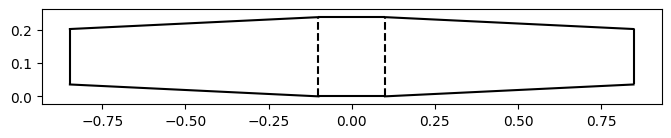

In [21]:
class UAV:
    __rho0 = 1.225
    rho = __rho0
    __g = 9.81
    __mu = 0.0289644
    __R = 8.3144598
    T = 273 + 15
    __visc = 18e-6
    def __init__(self, airfoil, S, mass, V, TR, AR, FusWidth, FusLength, cr=0, SweepQuart = True, Lt = 0, H = 0):
        self.__mass = mass
        self.W = self.__mass * self.__g
        self.S = S
        self.d = FusWidth
        self.L = FusLength
        self.FusS = 0.3 # Надо изменить 

        if (cr == 0):
            self.AR = AR
            self.TR = TR
            self.c = np.sqrt(self.S/self.AR)
            self.b = self.S/self.c
            self.cr = self.S / (self.d + (1 + self.TR)*(self.b - self.d)/2)
            self.ct = self.cr * self.TR

        elif (cr != 0):
            self.AR = AR
            self.cr = cr
            self.c = np.sqrt(self.S/self.AR)
            self.b = self.S/self.c
            self.ct = 2*(self.S - self.cr*self.d)/(self.b - self.d) - self.cr
            self.TR = self.ct/self.cr
            if (self.TR >= 1):
                self.TR = 1
                self.c = np.sqrt(self.S/self.AR)
                self.ct = self.c
                self.cr = self.ct

        ex = np.array([1., 0])
        ey = np.array([0, 1.])
        if (SweepQuart == False):
            a = 3/4*self.cr * ex + ey * 0.5 * (self.b - self.d) + ex*1/4*self.ct - ex*self.cr
            b = 3/4*self.cr * ex + ey * 0.5 * (self.b - self.d) - ex * 3/4*self.ct
            e = b + ex*0.5*self.ct
    
            self.SweepLE = np.acos(np.dot(ey, a) / (norm(a) * norm(ey)))
            self.SweepTE = np.acos(np.dot(ey, b) / (norm(b) * norm(ey)))

            self.SweepHalf = np.acos(np.dot(ey, e - ex*0.5*self.cr) / (norm(e - ex*0.5*self.cr) * norm(ey)))
            self.SweepQuart = 0
        elif (SweepQuart == True):
            self.SweepLE = np.atan((self.cr - self.ct) / (self.b - self.d))
            self.SweepQuart = np.tan(self.SweepLE) + self.cr*0.5/(self.b - self.d) * (self.TR - 1)
            self.SweepHalf = 0


        self.Lt = Lt
        self.Va = V
        self.H = H
        self.__Swet = 2*self.S - 2 * (self.d * self.cr)

        self.airfoilName = airfoil
        self.airfoilDat = np.loadtxt('{}.txt'.format(self.airfoilName), skiprows = 11, dtype=float)
        self.xtop = self.airfoilDat[:, 5]
        self.xbot = self.airfoilDat[:, 6]
        self.AOA = self.airfoilDat[:, 0]
        self.fxtop = interp1d(self.AOA, self.xtop) # интерполяционные функции для точки перехода
        self.fxbot = interp1d(self.AOA, self.xbot) # от ламинарного к турбулентному течению в зависимости от угла атаки

        self.airfoilGeometry = np.loadtxt('{}G.txt'.format(self.airfoilName), skiprows=1, dtype=float)
        self.thick = self.airfoilGeometry[0]
        self.thickLoc = self.airfoilGeometry[1]
        self.cam = self.airfoilGeometry[2]
        self.camLoc = self.airfoilGeometry[3]
        self.__GetAirDensity(H)

    def __GetAirDensity(self, h):
        self.rho = self.__rho0*np.exp(-self.__g * self.__mu * h / (self.__R * self.T))

    def GetReynolds(self, type = 'Mean', x = 0):
        '''Возвращае число Рейнольдса

        "Mean" - для САХ,

        "Root" - для корневой хорды,

        "Tip" - для концевой хорды,

        "Local" - для расстояния x от передней кромки крыла или
        фюзеляжа,

        "Fus" - для фюзеляжа,  

        Если число Рейнольдса превышает число Рейнольдса отрыва

        Recutoff = 38.21(c/k)**1.053

        (см. General Aviation Aircraft Design стр.682, формула (16-31))

        для поверхности c характерной норовностью k, то учитывается оно'''
        kcomp = 0.2e-5 * 0.3048 # Композит
        k3d = 20e-6 # для 3д принтера 20 мкм не обработаная поверхность перпендикулярон слоям
    
        if type == 'Mean':
            Recoff = 38.21*(self.c/kcomp)**1.053
            R = self.rho * self.Va * self.c / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R 
            
        if type == 'Root':
            Recoff = 38.21*(self.cr/kcomp)**1.053
            R = self.rho * self.Va * self.cr / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
            
        if type == 'Tip':
            Recoff = 38.21*(self.ct/kcomp)**1.053
            R = self.rho * self.Va * self.ct / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
            
        if type == 'Fus':
            Recoff = 38.21*(self.L/k3d)**1.053
            R = self.rho * self.Va * self.L / self.__visc
            if R >= Recoff:
                return Recoff
            else:
                return R
        
        if type == 'Local':
            return self.rho * self.Va * x / self.__visc
        
    def __GetSkinFriction(self, type, side, AOA):
        Re = self.GetReynolds(type)
        if (type != 'Fus'):
            if side == 'Top':
                x0 = 36.9*self.fxtop(AOA)**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxtop(AOA) - x0))**0.8
            elif side == 'Bottom':
                x0 = 36.9*self.fxbot(AOA)**0.625 * (1/Re)**0.375
                return 0.074/(Re**0.2) * (1 - (self.fxbot(AOA) - x0))**0.8
        else:
            x0 = 36.9 * 0.05**0.625 * (1/Re)**0.375
            return 0.074/(Re**0.2) * (1 - (0.05 - x0))**0.8

    
    def GetCDmin(self, crud = 1.2, AOA = 0):
        '''Функция подсчитывает минимальный коэффициент лобового сопротивления для всего самолета
        на основе геометрических характеристик крыла, хвостового оперения и фюзеляжа'''
        # Сопротивление крыла #################
        Ctip = 0.5 * (self.__GetSkinFriction(type='Tip', side='Top', AOA = AOA) + self.__GetSkinFriction(type='Tip', side='Bottom', AOA = AOA))
        Croot = 0.5 * (self.__GetSkinFriction(type='Root', side='Top', AOA = AOA) + self.__GetSkinFriction(type='Root', side='Bottom', AOA = AOA))
        Cfw = 0.5 * (Croot + Ctip)
        Cdw = self.__Swet / self.S * Cfw

        # if (abs(self.thickLoc - 0.3) <=0.05):
        #     FFw = 1 + 2*(self.thick) + 60(self.thick)**4
        # elif (self.thickLoc >= 0.4 and self.thickLoc <= 0.5):
        #     FFw = 1 + 1.2*(self.thick) + 70(self.thick)**4
        FFw = (3.3*(self.thick) - 0.008*(self.thick)**2 + 27*(self.thick)**3)*(np.cos(self.SweepHalf))**2 + 1
        Cdw = FFw * Cdw
        #######################################

        # Сопротивление фюзеляжа ##############
        f = self.L/2 * np.sqrt(4 / self.d**2)
        ReF = self.GetReynolds(type='Fus')
        if (ReF <= 1e5):
            Cdf = 1.328/(ReF)**0.5 * (1 + f**-1.5) + 0.11*f**-2
        elif (ReF > 1e5):
            FFf1 = 1 + 1.5*f**-1.5 + 7*f**-3
            FFf2 = 1 + 2.2*f**-1.5 + 3.8*f**-3

            FFf3 = 1 + 60*f**-3 + f/400 #This provides a good correlation for fineness ratios 
            #(f) above 6 as is typical for high-speed and military aircraft, but 
            #seems to overestimate drag for fineness ratios much below 5.

            FFf4 = 2.939 - 0.7666*f + 0.1328*f**2 - 0.01074*f**3 + 3.275e-4*f**4
            FFf5 = 1 + 2.2*f**-1.5 - 0.9*f**-3
            FFf6 = 0.9 + 5*f**-1.5 + f/400 # From Raymer

            FFf = np.mean([FFf1, FFf2, FFf3, FFf4, FFf5, FFf6])
        Cdf = self.__GetSkinFriction(type='Fus', side = 'Top',AOA=AOA) * FFf * (self.FusS) / self.S
        #######################################

        # Сопротивление хвостового оперения ##################

        ######################################################

        
        
    def GetAirfoilCl(self, a):
        '''Возвращает значение коэффициента подъемной
        силы профиля крыла для заданного угла атаки'''
        alpha = self.airfoilDat[:, 0]
        Cl = self.airfoilDat[:, 1]
        fCl = interp1d(alpha, Cl)
        return fCl(a)
    
    def GetAirfoilCd(self, a):
        '''Возвращает значение коэффициента силы 
        лобового сопротивления профиля крыла для заданного угла атаки'''
        alpha = self.airfoilDat[:, 0]
        Cd = self.airfoilDat[:, 2]
        fCd = interp1d(alpha, Cd)
        return fCd(a)
    
    def GetAirfoilCd0(self):
        '''Возвращает значение коэффициента силы 
        лобового сопротивления профиля крыла для 0 угла атаки'''
        alpha = self.airfoilDat[:, 0]
        Cd = self.airfoilDat[:, 2]
        fCd = interp1d(alpha, Cd)
        return fCd(0)
    
    def GetAirfoilCdmin(self):
        cur = 10
        a = 0
        alpha = self.airfoilDat[:, 0]
        Cd = self.airfoilDat[:, 2]
        fCd = interp1d(alpha, Cd)
        for el in np.linspace(-5, 10, 1000):
            if (fCd(el) < cur):
                cur = fCd(el)
                a = el
        return (a, cur)
    
    def GetAirfoilCm(self, a):
        alpha = self.airfoilDat[:, 0]
        Cm = self.airfoilDat[:, 4]
        fCm = interp1d(alpha, Cm)
        return fCm(a)
    
    def GetAirfoilClmax(self):
        curr = 0
        a=0
        alpha = self.airfoilDat[:, 0]
        Cl = self.airfoilDat[:, 1]
        fCl = interp1d(alpha, Cl)
        for el in np.linspace(0, alpha[-1], 1000):
            if fCl(el) >= curr:
                curr = fCl(el)
                a = el
        return (a, curr)
    
    def GetAirfoilClslope(self, a):
        '''Возвращает наклон кривой подъеного коэффициента
        профиля в 1/рад'''
        alpha = self.airfoilDat[:, 0]
        Cl = self.airfoilDat[:, 1]
        fCl = interp1d(alpha, Cl)
        return (-fCl(a) + fCl(a + 0.5))/0.5 *180/np.pi
    
    def GetCLmax(self):
        '''Возвращает максимально достижимый коэффициент подъемной силы
        для крыла заданных размеров'''
        return 0.9 * np.cos(self.SweepQuart) * self.GetAirfoilClmax()[1]
    
    def GetAirfoilCl0(self):
        '''Возвращает коэффициент подъемной силы профиля
        при нулевом угле атаки'''
        alpha = self.airfoilDat[:, 0]
        Cl = self.airfoilDat[:, 1]
        fCl = interp1d(alpha, Cl)
        return fCl(0)

    def GetCL0(self):
         az = (-1)*self.GetAirfoilCl0()/self.GetAirfoilClslope(0)
         return abs(az)*self.GetCLslope()

    def GetZeroLiftAOA(self):
        return (-1)*self.GetAirfoilCl0()/self.GetAirfoilClslope(0)
    
    def GetCLcruise(self):
        return self.GetCL0() + self.W/(self.GetDynamicPressure() * self.S) + self.GetCLslope()*self.GetZeroLiftAOA()
    
    def GetDynamicPressure(self):
        self.__GetAirDensity(self.H)
        if self.Va != 0:
            return self.rho * self.Va**2 / 2
        else:
            return self.rho * self.GetCruiseSpeed()**2 / 2
    
    def GetSpeedSound(self):
        return np.sqrt(1.4 * self.__R * self.T/self.__mu)
    
    def GetCLslope(self):
        """Расчитывает наклон кривой коэффициента подъемной силы
        для секции крыла в 1/rad"""
        beta = 1 - (self.Va/self.GetSpeedSound())**2
        k = self.GetAirfoilClslope(0) / (2*np.pi)
        x = self.AR/k * (beta**2 + np.tan(self.SweepHalf)**2)**0.5
        eta = 0.98
        return 2*np.pi*self.AR / (2 + np.sqrt(x**2 + 4))*eta
    
    def GetOsvald(self, method = 'A'):
        if (method == 'A'):
            return 2 / (2 - self.AR + np.sqrt(4 + self.AR**2*(1 + np.tan(self.SweepQuart))))
        if (method == 'B'):
            r = 0.38 - self.SweepLE * 57.3/3000 + (self.SweepLE * 57.3)**2/15000
            u = 0.98
            t = self.d / self.b
            CDmin = self.GetCDmin()
            return 1 / (np.pi*self.AR*r*CDmin + 1 / ((1 + 0.03*t - 2*t**2)*u))
        
    def PlotWing(self):
        '''Функция рисует крыло'''
        fig, ax = plt.subplots(1,1, figsize = (8,4))
        ax.set_xlim(-self.b/2*1.1, self.b/2*1.1)
        ax.set_ylim(-0.1*self.cr, 1.1*self.cr)
        ax.set_aspect('equal')
        ax.hlines(0, 0, self.d/2, color = 'black')
        ax.hlines(self.cr, 0, self.d/2, color='black')
        ax.vlines(self.d/2, 0, self.cr, color = 'black', linestyles='--')
        ax.plot([self.d/2, self.b/2,], [0, self.cr/2 - self.ct/2], color = 'black')
        ax.plot([self.d/2, self.b/2,], [self.cr, self.cr/2 + self.ct/2], color='black')
        ax.vlines(self.b/2, self.cr/2 - self.ct/2, self.cr/2 + self.ct/2, color = 'black')
        ax.hlines(0, 0, -self.d/2, color = 'black')
        ax.hlines(self.cr, 0, -self.d/2, color='black')
        ax.vlines(-self.d/2, 0, self.cr, color = 'black', linestyles='--')
        ax.plot([-self.d/2, -self.b/2,], [0, self.cr/2 - self.ct/2], color = 'black')
        ax.plot([-self.d/2, -self.b/2,], [self.cr, self.cr/2 + self.ct/2], color='black')
        ax.vlines(-self.b/2, self.cr/2 - self.ct/2, self.cr/2 + self.ct/2, color = 'black')


p = UAV('SD7032', S = 0.35, mass = 3.5, V = 18, TR = 0.7, AR = 8.2, FusWidth=0.2, FusLength= 1.4, cr=0, SweepQuart=True)
p.GetReynolds(type='Fus'), p.GetAirfoilCdmin(), p.PlotWing(), p.thick, p.GetCDmin()

### Модель коэффициента подъемной силы
$$C_L = C_{L_{0}} + C_{L_{\alpha}}\alpha + C_{L_{\delta_{e}}}\delta_{e} + C_{L_{q}}\frac{c}{2v_a}q$$

#### Наклон кривой коэффициента подъемной силы $C_{L_{\alpha}}$
![.](LiftCurveSlope.jpg)
![.](LiftCurveSlopeRaymer.jpg)

#### Угол атаки нулевой подъемной силы

![.](ZeroLiftCoef.jpg)

#### Коэффициент эффективности Освальда

![.](OsvaldEfficiency.jpg)

#### Требуемый коэффициент подъемной силы при заданной скорости полета и массе ЛА

![.](CruiseLiftCoefficient.jpg)


### Модель коэффициента лобового сопротивления
$$C_D = C_{D_{0}} + C_{D{\alpha}}\alpha + C_{D_{\delta_{e}}}\delta_{e} + C_{D_{q}}\frac{c}{2v_a}q$$
Для более точной оценки лобового сопротивления в зависимости от угла атаки и геометрических характеристик ЛА используем дополненую квадратичную модель коэффициента лобового сопроивления
$$C_{D_{0}} + C_{D_{\alpha}}\alpha = C_{D}(\alpha) = C_{D_{0}} + C_{D_{i}} = C_{D_{0}} + \frac{(C_{L}(\alpha) - C_{LmD})^{2}}{\pi e AR}$$
где $C_{D_{0}}$ - паразитное сопроивление, $C_{D_{i}}$ - индуцированное сопротивление засчет подъемной силы, $e$ - коэффициент эффективности Освальда
$$C_{D_{\alpha}} = \frac{\partial C_{D}(\alpha)}{\partial \alpha} = \frac{2}{\pi e AR}(C_{L_{0}} + C_{L_{\alpha}} - C_{LmD})C_{L_{\alpha}}$$
$$C_{D_{0}} = (C_{D_{add}} + \frac{1}{S}(\sum_{i}(C_{f_{i}} \times FF_{i} \times S_{wet_{i}} \times IF_{i})))k_{crud}$$
где $C_{f}$ - коэффициент сил трения

$FF (Form factor)$ - множитель, учитывающий форму обтекаемого тела (крыла, фюзеляжа)

$S_{wet}$ - полная площадь поверхности тела, которая обтекается воздухом

$IF (Interference factor)$ - множитель, учитывающий взаимное расположение и влияние элементов на друг друга 

$C_{D_{add}}$ - дополнительный коэффициент сопротивления засчет элементов конструкции, неявляющихся крылом или фюзеляжем, например, подвесных конструкций на крыле

$k_{crud}$ (Cumulative Result of Undesirable
 Drag) - множитель, учитывающий неидеальность конструкции, отличие расчетных форм поверхностей от действительных

Суммирирование производится по всем рассматриваемым элементам: крыло, фюзеляж, хвостовое оперение

#### Оценка паразитного сопротивления $C_{D_{0}}$
![.](CdminEstimationAlgorithm.jpg)

#### Фактор взаимодействия элементов конструкции между собой
![.](InterferenceFactor.jpg)

#### Неровность поверхности материала

Если понимать данные в таблице, как характерный размер неровностей на поверхности материала, то для детали изготовленной на 3Д принере-  ?
![.](SurfaceRoughness.jpg)

#### CRUD $k_{crud}$
![.](CRUDfactor.jpg)

#### Коэффициент силы трения для профиля крыла, хвостового оперения
![.](SkinFrictionCoef.jpg)

In [3]:
m = 3.5 #масса ЛА
v_a = 18 #средняя ветровая скорость
C_L = 0.45 #коэффициент подъёмной силы для профиля SD7032

q = pho*(v_a**2)/2
S_w = m*g/(q*C_L)

dm(md(f"$ S_w = {round(S_w, 2)} $"))

NameError: name 'pho' is not defined

In [ ]:
#ИНИЦИАЛИЗАЦИЯ
C_R = 0.25 #корневая хорда крыла
C_e = 0.2 #концевая хорда крыла
TR_w = C_e/C_R #сужение крыла
AR_w = 7 #удлинение крыла
d = 0.2 # длина центроплана

#РАСЧЁТ
C_m = 0.5*(C_R+C_e) #полусумма оснований
b_w = AR_w*(C_m + np.sqrt(C_m**2 - 4*d*(C_m-C_R)/AR_w))/2 #размах крыла
C_w = b_w/AR_w #средняя хорда крыла (из b_w)

#ВЫВОД
dm(md(f"$b_w = {round(b_w, 2)}, C_w = {round(C_w, 2)}$"))

$b_w = 1.6, C_w = 0.23$

In [ ]:
#ИНИЦИАЛИЗАЦИЯ
c_HT = 0.5
c_VT = 0.02
L = 0.525

#РАСЧЁТ
S_VT = 0.5*c_VT*b_w*S_w/L
TS_HT = c_HT*C_w*S_w/L 

#ВЫВОД
dm(md(f"$S_{{VT}} =  {round(S_VT,3)}$"))
dm(md(f"$S_{{HT}} =  {round(S_HT,3)}$"))

$S_{VT} =  0.012$

NameError: name 'S_HT' is not defined

In [ ]:
#ИНИЦИАЛИЗАЦИЯ
AR_t = 3 #удлинение хвостового оперения

#РАСЧЁТ
#средние хорды вертикального и горизонтального оперений
C_HT = np.sqrt(S_HT/AR_t)
C_VT = np.sqrt(S_VT/AR_t)
#размахи вертикального и горизонтального оперений
b_HT = S_HT/C_HT
b_VT = S_VT/C_VT
#ВЫВОД
dm(md(f"$C_{{VT}} =  {round(C_VT,3)}$"))
dm(md(f"$C_{{HT}} =  {round(C_HT,3)}$"))
dm(md(f"$b_{{VT}} =  {round(b_VT,3)}$"))
dm(md(f"$b_{{HT}} =  {round(b_HT,3)}$"))
# print("b_VT = ", round(b_VT,3))
# print("C_HT = ", round(C_HT,3))
# print("b_HT = ", round(b_HT,3))

$C_{VT} =  0.062$

$C_{HT} =  0.167$

$b_{VT} =  0.187$

$b_{HT} =  0.5$

In [ ]:
#ИНИЦИАЛИЗАЦИЯ

#РАСЧЁТ
#угол наклона лопатки относительно горизонтальной плоскости
theta = np.arctan(b_VT/b_HT)
S_T = S_HT/np.cos(theta) #площадь лопатки V_tail

#ВЫВОД
dm(md(f"$\\theta = {round(theta*360/(2*np.pi), 2)}\\degree$"))
dm(md(f"$S_T = {round(S_T, 3)}$"))

$\theta = 20.51\degree$

$S_T = 0.089$

In [ ]:
#ИНИЦИАЛИЗАЦИЯ
TR_t = 0.5 #сужение для хвостового оперения
b_T = b_HT/2 #длина лопатки

#РАСЧЁТ
#средняя, корневая и концевая хорды лопаток V-tail
c = np.sqrt(S_T/AR_t)
c_r = c/0.75
c_e = 0.5*c_r

#ВЫВОД
dm(md(f"$c = {round(c, 3)}$"))
dm(md(f"$c_r = {round(c_r, 3)}$"))
dm(md(f"$c_e = {round(c_e, 3)}$"))

$c = 0.172$

$c_r = 0.23$

$c_e = 0.115$

In [ ]:
df = pd.read_csv('SD7032 C_L.csv', delimiter = '\t')
alpha = df['alpha'] #угол атаки в градусах
CL = df['CL']
start = 13
stop = 67
t_approx = np.polyfit(alpha[start:stop], CL[start:stop], 1)
f_approx = np.poly1d(t_approx)[1]*360/(2*np.pi) #тангенс угла наклона линейной части поляры крыла C_l(alpha)
C_L_alpha = 0.9*f_approx #коэффициент при первой степени разложения коэффициента подъёмной силы по альфа  
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha,3)} , SD7032$"))


$C_{L\alpha} =  5.463 , SD7032$

In [ ]:
df1 = pd.read_csv('xf-n0009sm-il-500000.csv', delimiter = ',')
alpha = df1['Alpha'] #угол атаки в градусах
CL = df1['Cl']
start = 40
stop = 68
t_approx = np.polyfit(alpha[start:stop], CL[start:stop], 1)
f_approx = np.poly1d(t_approx)[1]*360/(2*np.pi) #тангенс угла наклона линейной части поляры крыла C_l(alpha)
C_L_alpha1 = 0.9*f_approx #коэффициент при первой степени разложения коэффициента подъёмной силы по альфа  
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha1,3)}, NACA0009$"))

$C_{L\alpha} =  7.428, NACA0009$

In [ ]:
M = q*S_w*C_L
C1 = C_L_alpha1
varphi = np.sqrt(M/(q*L*S_w*C1*2)) #угол установки
X_cp = S_T*C1*L*0.9/(S_w*C_L_alpha)
dm(md(f"$\\varphi = {round(varphi*360/(2*np.pi), 1)} \\degree$"))
dm(md(f"$X_{{c.p}} = {round(X_cp , 3)}$"))

$\varphi = 13.8 \degree$

$X_{c.p} = 0.149$

In [ ]:
#РЕЗУЛЬТАТЫ
dm(md(f"$ S_w = {round(S_w, 2)} $"))
dm(md(f"$b_w = {round(b_w, 2)}, C_w = {round(C_w, 2)}$"))
dm(md(f"$S_{{VT}} =  {round(S_VT,3)}$"))
dm(md(f"$S_{{HT}} =  {round(S_HT,3)}$"))
dm(md(f"$C_{{VT}} =  {round(C_VT,3)}$"))
dm(md(f"$C_{{HT}} =  {round(C_HT,3)}$"))
dm(md(f"$b_{{VT}} =  {round(b_VT,3)}$"))
dm(md(f"$b_{{HT}} =  {round(b_HT,3)}$"))
dm(md(f"$\\theta = {round(theta*360/(2*np.pi), 2)}\\degree$"))
dm(md(f"$S_T = {round(S_T, 3)}$"))
dm(md(f"$c = {round(c, 3)}$"))
dm(md(f"$c_r = {round(c_r, 3)}$"))
dm(md(f"$c_e = {round(c_e, 3)}$"))
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha,3)} , SD7032$"))
dm(md(f"$C_{{L\\alpha}} =  {round(C_L_alpha1,3)}, NACA0009$"))
dm(md(f"$X_{{c.p}} = {round(X_cp , 3)}$"))
dm(md(f"$\\varphi = {round(varphi*360/(2*np.pi), 1)} \\degree$"))

$ S_w = 0.38 $

$b_w = 1.6, C_w = 0.23$

$S_{VT} =  0.012$

$S_{HT} =  0.083$

$C_{VT} =  0.062$

$C_{HT} =  0.167$

$b_{VT} =  0.187$

$b_{HT} =  0.5$

$\theta = 20.51\degree$

$S_T = 0.089$

$c = 0.172$

$c_r = 0.23$

$c_e = 0.115$

$C_{L\alpha} =  5.463 , SD7032$

$C_{L\alpha} =  7.428, NACA0009$

$X_{c.p} = 0.149$

$\varphi = 13.8 \degree$